In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_model
from adaptive_filter.cerebellum import AdaptiveFilterCerebellum
from cmac import CMAC

from tqdm import tqdm  # progress bar

In [3]:
angles_diff = np.array([[0, 0]])
inp = np.array([[0, 0, 0, 0]])
abs_px = np.array([[0, 0, 0, 0]])

# datasets = ["data/training_data.p"]
# for i in range(2, 32):
#     datasets.append("data/training_data"+str(i)+".p")
#
# for dataset in datasets:
#     print("Processing {}".format(dataset))
#     # Load data
#     data = pickle.load(open(dataset, "rb"))
#     angles = data[:, :2]
#     angles /= 90.0
#     end_pos = data[:, 2:]
#     end_pos = (end_pos - 200) / 200
#
#     for i, angle in tqdm(enumerate(angles)):
#         for j, angle2 in enumerate(angles):
#             if i!=j:
#                 angles_diff = np.concatenate((angles_diff, [angle2]))
#                 inp = np.concatenate((inp, [np.concatenate((end_pos[j] - end_pos[i], angle))]))
#                 abs_px = np.concatenate((abs_px, [np.concatenate((end_pos[i], end_pos[j]))]))
# with open('processed_abs.p', 'wb') as file:
#     pickle.dump((inp, angles_diff, abs_px), file)
with open('processed_abs.p', 'rb') as file:
    inp, angles_diff, abs_px = pickle.load(file)

In [4]:
inp = inp[1:, :]
angles_diff = angles_diff[1:, :]
abs_px = abs_px[1:, :]
print(inp)
print(angles_diff)
print("Training set generated")
# Use GPU?
device = 'cpu'
if torch.cuda.is_available():
    print("Using GPU")
    device = 'cuda'
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')

x = torch.from_numpy(inp).float()
y = torch.from_numpy(angles_diff).float()
print(y)
if device == 'cuda':
    x = x.cuda()
    y = y.cuda()
# DONE split the training set and test set
print(len(x.cpu()))
train, test = torch.utils.data.random_split(range(len(x)), [0.8, 0.2])
x_train, y_train, abs_px_train = x[train.indices], y[train.indices], abs_px[train.indices]
x_test, y_test, abs_px_test = x[test.indices], y[test.indices], abs_px[test.indices]
# Eventually normalize the data

[[-0.02       -0.04       -0.97981771 -0.95052083]
 [-0.025      -0.105      -0.97981771 -0.95052083]
 [ 0.1        -0.13       -0.97981771 -0.95052083]
 ...
 [-0.015       0.005      -0.00976562  0.84309896]
 [-0.01        0.01       -0.00976562  0.84309896]
 [-0.01        0.005      -0.00976562  0.84309896]]
[[-0.8984375  -0.95377604]
 [-0.78450521 -0.95703125]
 [-0.68033854 -0.95703125]
 ...
 [-0.16601562  0.84309896]
 [-0.11393229  0.84309896]
 [-0.06184896  0.84309896]]
Training set generated
Using GPU
tensor([[-0.8984, -0.9538],
        [-0.7845, -0.9570],
        [-0.6803, -0.9570],
        ...,
        [-0.1660,  0.8431],
        [-0.1139,  0.8431],
        [-0.0618,  0.8431]])
456600


In [5]:
# Define neural network - an example
model = torch_model.Net(4, 50, 2)
model.load_state_dict(torch.load('closed_loop_trained_model.pth'))
model.to(device)
model.eval()

Net(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [48]:
n_inputs = 4
n_outputs = 2
n_bases = 10
beta = 1e-7

# c = AdaptiveFilterCerebellum(n_inputs, n_outputs, n_bases, beta)
x_min = [-2] * 2
x_max = [2] * 2
c = [CMAC(n_bases, x_min, x_max, beta) for _ in range(2)]

In [50]:
num_epochs = 10
mse_nn_hist = np.zeros(num_epochs)
mse_af_hist = np.zeros(num_epochs)
# c[0].beta = beta
# c[1].beta = beta
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}")
    x, y, abs_px = x_train, y_train, abs_px_train
    curr_px = x[:, :2].cpu().numpy()
    curr_joints = x[:, 2:].cpu().numpy()
    joints_pred_raw = model(x).cpu()
    joints_pred = joints_pred_raw.detach().numpy()[:] * 90
    joints_diff = joints_pred - curr_joints

    K = 0.6
    samples = len(joints_diff)
    af_preds = np.zeros((samples, 2))

    for i in tqdm(range(len(joints_diff))):
        # cj = curr_joints[i, :]
        # pj = joints_pred[i, :]
        dj = joints_diff[i]
        # print(dj)
        # c.step(np.concatenate((cj, pj)), dj)
        # print(abs_px[i, [1,3]])
        pred = np.array([
            c[0].predict(abs_px[i, [1, 3]]),
            c[1].predict(abs_px[i, [0, 2]]),
        ])
        af_preds[i, :] = pred
        c[0].learn(dj[0])
        c[1].learn(dj[1])
    joints_out = curr_joints + af_preds + K * joints_diff
    joints_true = y.cpu().numpy() * 90
    nn_out = curr_joints + K * joints_diff
    mse_nn_hist[epoch] = np.mean(np.abs(nn_out - joints_true))
    mse_af_hist[epoch] = np.mean(np.abs(joints_out - joints_true))
    print(f'NN MSE: {mse_nn_hist[epoch]}')
    print(f'AF MSE: {mse_af_hist[epoch]}')

Epoch 0/10


100%|██████████| 365280/365280 [01:14<00:00, 4871.02it/s]


NN MSE: 23.21622657775879
AF MSE: 19.345015322232065
Epoch 1/10


100%|██████████| 365280/365280 [01:15<00:00, 4814.23it/s]


NN MSE: 23.21622657775879
AF MSE: 19.13216433197715
Epoch 2/10


100%|██████████| 365280/365280 [01:19<00:00, 4595.00it/s]


NN MSE: 23.21622657775879
AF MSE: 18.950854854194205
Epoch 3/10


100%|██████████| 365280/365280 [01:07<00:00, 5383.40it/s]


NN MSE: 23.21622657775879
AF MSE: 18.80284489137118
Epoch 4/10


100%|██████████| 365280/365280 [01:08<00:00, 5308.74it/s]


NN MSE: 23.21622657775879
AF MSE: 18.68976550630543
Epoch 5/10


100%|██████████| 365280/365280 [01:13<00:00, 4969.72it/s]


NN MSE: 23.21622657775879
AF MSE: 18.612773338704198
Epoch 6/10


100%|██████████| 365280/365280 [01:17<00:00, 4733.15it/s]


NN MSE: 23.21622657775879
AF MSE: 18.57414149299658
Epoch 7/10


100%|██████████| 365280/365280 [01:23<00:00, 4365.86it/s]


NN MSE: 23.21622657775879
AF MSE: 18.574337720198947
Epoch 8/10


100%|██████████| 365280/365280 [01:13<00:00, 4987.76it/s]


NN MSE: 23.21622657775879
AF MSE: 18.613970810424295
Epoch 9/10


100%|██████████| 365280/365280 [01:11<00:00, 5094.82it/s]

NN MSE: 23.21622657775879
AF MSE: 18.693251245297137


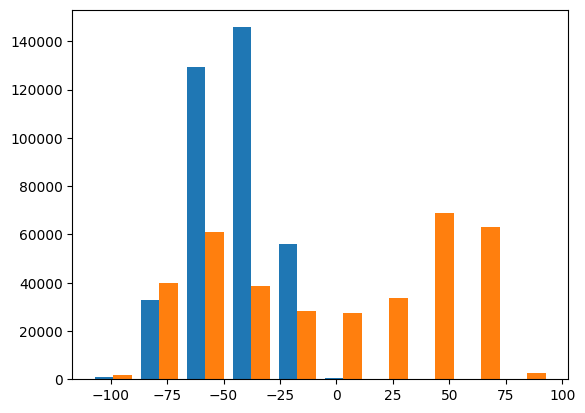

In [39]:
_ = plt.hist(joints_diff)

In [51]:
# c[0].beta = 0.0
# c[1].beta = 0.0
x, y, abs_px = x_test, y_test, abs_px_test
curr_joints = x[:, 2:].cpu().numpy()
joints_pred_raw = model(x).cpu()
joints_pred = joints_pred_raw.detach().numpy()[:] * 90
joints_diff = joints_pred - curr_joints
K = 0.6
samples = len(joints_diff)
af_preds = np.zeros((samples, 2))

for i in tqdm(range(samples)):
    # cj = curr_joints[i, :]
    # pj = joints_pred[i, :]
    # dj = joints_diff[i]
    pred = np.array([
        c[0].predict(abs_px[i, [1, 3]]),
        c[1].predict(abs_px[i, [0, 2]]),
    ])
    af_preds[i, :] = pred

joints_out = curr_joints + af_preds + K * joints_diff
joints_true = y.cpu().numpy() * 90
nn_out = curr_joints + K * joints_diff

100%|██████████| 91320/91320 [00:18<00:00, 5016.24it/s]


In [52]:
mse_nn = np.mean(np.abs(nn_out - joints_true))
mse_af = np.mean(np.abs(joints_out - joints_true))

print(f'NN MSE: {mse_nn}')
print(f'AF MSE: {mse_af}')


NN MSE: 23.20488166809082
AF MSE: 18.682899318493625


In [53]:
with open('cmac_trained.p', 'wb') as file:
    pickle.dump(c, file)

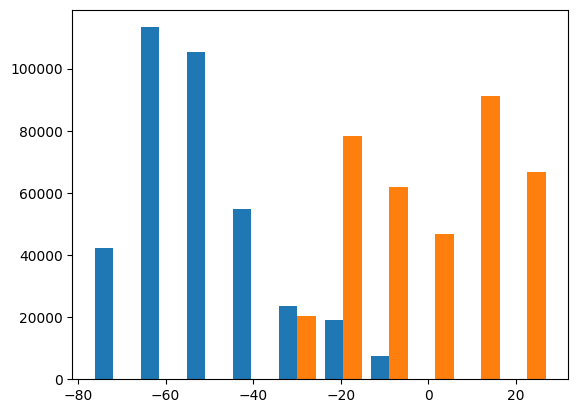

In [46]:
_ = plt.hist(af_preds)
# _ = plt.hist(nn_out)
# _ = plt.hist(joints_true)
# _ = plt.hist(joints_out)

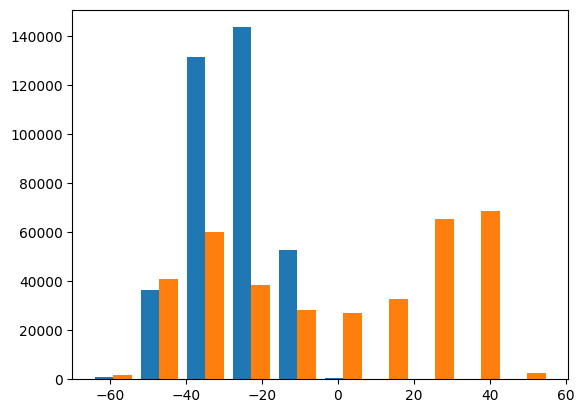

In [41]:
_ = plt.hist(nn_out)

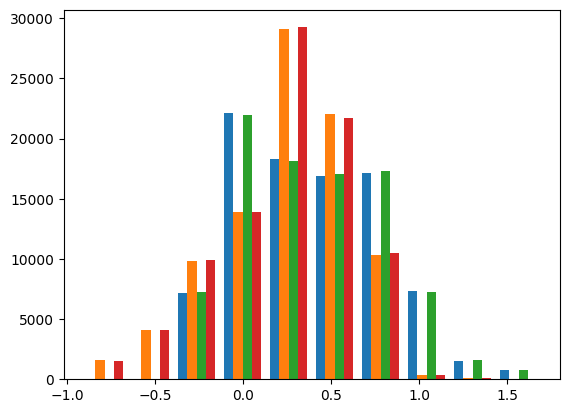

In [24]:
_ = plt.hist(abs_px)